In [1]:
"""
To install libraries, please run the following command.

```sh
pip install matplotlib numpy tensorflow scikit-learn
```

Dependency
```
matplotlib==3.9.0
numpy==1.26.4
scikit-learn==1.5.0
tensorflow==2.16.1
```
"""

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [2]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [3]:
train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

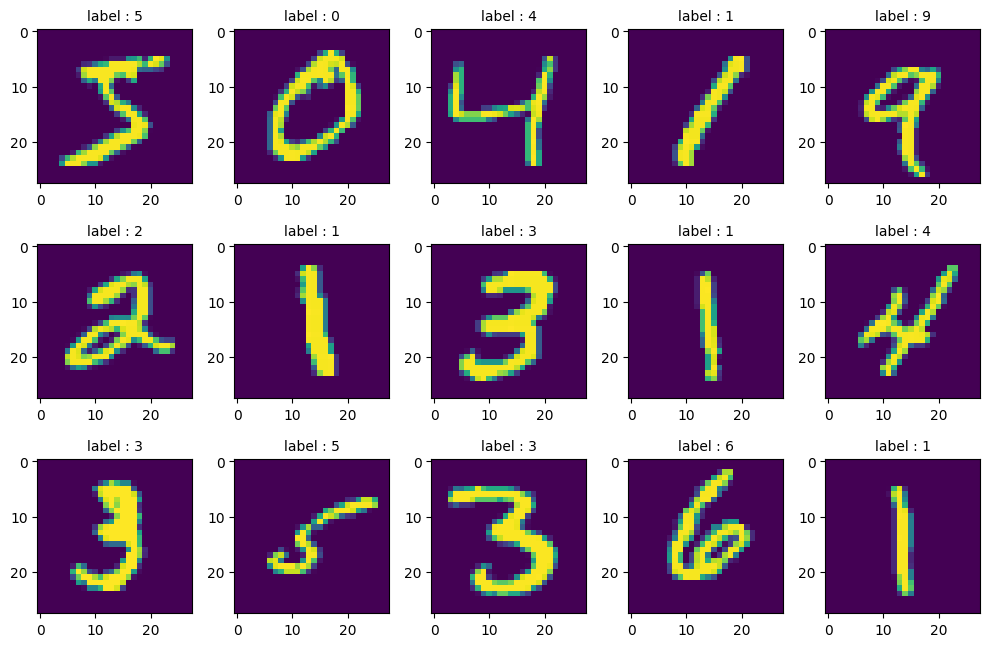

In [4]:
nrows, ncols = 3, 5

fig = plt.figure(figsize=(2 * ncols, 2.2 * nrows))

for i in range(nrows):
    for j in range(ncols):
        idx = i * ncols + j
        ax = fig.add_subplot(nrows, ncols, idx + 1)
        ax.imshow(train_images[idx])
        ax.set_title(f"label : {train_labels[idx]}", fontdict={"size": 10})

fig.tight_layout()

In [5]:
x_train, x_valid, t_train, t_valid = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=42, shuffle=True
)
x_test, t_test = test_images, test_labels

In [6]:
x_train.shape, t_train.shape, x_valid.shape, t_valid.shape, x_test.shape, t_test.shape

((48000, 28, 28),
 (48000,),
 (12000, 28, 28),
 (12000,),
 (10000, 28, 28),
 (10000,))

In [7]:
eps = np.finfo(np.float32).eps


class Linear:
    def __init__(self, in_features: int, out_features: int):
        """

        Args:
            in_features (int): denoted as D_in
            out_features (int): denoted as D_out
        """

        self.W = np.random.randn(in_features, out_features).astype(
            np.float32
        )  # (D_in, D_out)
        self.b = np.zeros(shape=(out_features,))  # (D_out, )

        self.x: np.ndarray | None = None  # (N, D_in)
        self.dW: np.ndarray | None = None  # (D_in, D_out)
        self.db: np.ndarray | None = None  # (D_out, )

    def forward(self, x: np.ndarray) -> np.ndarray:
        """

        Args:
            x (np.ndarray): shape is (N, D_in)

        Returns:
            np.ndarray: shape is (N, D_out)
        """

        self.x = x

        return x @ self.W + self.b[np.newaxis, :]

    def backward(self, dout: np.ndarray) -> np.ndarray:
        """

        Args:
            dout (np.ndarray): shape is (N, D_out)

        Returns:
            np.ndarray: dx, shape is (N, D_in)
        """

        dx = dout @ self.W.T
        self.dW = self.x.T @ dout
        self.db = dout.sum(axis=0)

        return dx

    def parameters(self) -> list[np.ndarray]:
        return [self.W, self.b]

    def gradients(self) -> list[np.ndarray]:
        return [self.dW, self.db]


class Relu:
    def __init__(self):
        self.mask: np.ndarray | None = None

    def forward(self, x: np.ndarray) -> np.ndarray:
        self.mask = x > 0
        return np.where(self.mask, x, 0)

    def backward(self, dout: np.ndarray) -> np.ndarray:
        return np.where(self.mask, dout, 0)

    def parameters(self) -> list[np.ndarray]:
        return []

    def gradients(self) -> list[np.ndarray]:
        return []


class SoftmaxAndCrossEntropy:
    def __init__(self):
        self.t: np.ndarray | None = None  # (N, num_classes)
        self.y: np.ndarray | None = None  # (D_in, num_classes)

    def forward(self, x: np.ndarray, t: np.ndarray) -> np.ndarray:
        """

        Args:
            x (np.ndarray): shape is (N, num_classes)
            t (np.ndarray): one-hot vector, shape is (N, num_classes)

        Returns:
            np.ndarray: loss, scalar value
        """

        x_exp = np.exp(x)
        y = x_exp / x_exp.sum(axis=1, keepdims=True)  # probabilities, (N, num_classes)
        loss = np.mean(np.sum(-t * np.log(y + eps), axis=1))

        self.t = t
        self.y = y

        return loss

    def backeard(self) -> np.ndarray:
        """

        Returns:
            np.ndarray: dx, shape is (N, num_classes)
        """
        return self.y - self.t


class SGD:
    def optimize(
        self, parameters: list[np.ndarray], gradients: list[np.ndarray], lr: float
    ):
        for parameter, gradient in zip(parameters, gradients):
            parameter -= lr * gradient

In [8]:
def convet_to_one_hot_vector(x: np.ndarray, num_classes: int) -> np.ndarray:
    """

    Args:
        x (np.ndarray): shape is (N, )

    Returns:
        np.ndarray: shape is (N, num_classes), dtype np.int8
    """

    return np.eye(N=num_classes, dtype=np.int8)[x]


def batch_generator(x: np.ndarray, t: np.ndarray, batch_size: int, shuffle=True):
    num_samples = len(x)

    all_indicies = np.arange(num_samples)
    if shuffle:
        np.random.shuffle(all_indicies)

    base_index = 0
    while base_index < num_samples:
        target_indices = all_indicies[base_index : base_index + batch_size]
        yield (
            x[target_indices],
            t[target_indices],
        )
        base_index += batch_size

In [9]:
class Net:
    def __init__(self):
        self.layers = [
            Linear(in_features=784, out_features=64),
            Relu(),
            Linear(in_features=64, out_features=10),
        ]

    def forward(self, x: np.ndarray) -> np.ndarray:
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, dout: np.ndarray) -> np.ndarray:
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def parameters(self) -> list[np.ndarray]:
        return [param for layer in self.layers for param in layer.parameters()]

    def gradients(self) -> list[np.ndarray]:
        return [grad for layer in self.layers for grad in layer.gradients()]


net = Net()
softmax_and_cross_entropy = SoftmaxAndCrossEntropy()
optimizer = SGD()

num_epochs = 10
lr = 0.001
batch_size = 64

for epoch in range(num_epochs):
    train_num_samples = 0
    train_loss_cache = []
    train_acc_cache = []

    valid_num_samples = 0
    valid_loss_cache = []
    valid_acc_cache = []

    for x, t in batch_generator(x_train, t_train, batch_size, shuffle=True):
        N = len(x)

        x = np.array(x, dtype=np.float32).reshape(-1, 784) / 255.0  # (N, 784)
        t_onehot = convet_to_one_hot_vector(t, num_classes=10)  # (N, 10)

        x = net.forward(x)  # (N, 10)
        loss = softmax_and_cross_entropy.forward(x, t_onehot)

        dout = softmax_and_cross_entropy.backeard()
        dout = net.backward(dout)

        optimizer.optimize(
            parameters=net.parameters(), gradients=net.gradients(), lr=lr
        )

        t_pred = x.argmax(axis=1)

        train_num_samples += N
        train_loss_cache.append(N * loss)
        train_acc_cache.append(np.sum(t == t_pred))

    for x, t in batch_generator(x_valid, t_valid, batch_size, shuffle=False):
        N = len(x)

        x = np.array(x, dtype=np.float32).reshape(-1, 784) / 255.0  # (N, 784)
        t_onehot = convet_to_one_hot_vector(t, num_classes=10)  # (N, 10)

        x = net.forward(x)  # (N, 10)
        loss = softmax_and_cross_entropy.forward(x, t_onehot)

        t_pred = x.argmax(axis=1)

        valid_num_samples += N
        valid_loss_cache.append(N * loss)
        valid_acc_cache.append(np.sum(t == t_pred))

    train_loss = np.array(train_loss_cache).sum() / train_num_samples
    train_acc = np.array(train_acc_cache).sum() / train_num_samples

    valid_loss = np.array(valid_loss_cache).sum() / valid_num_samples
    valid_acc = np.array(valid_acc_cache).sum() / valid_num_samples

    print(
        f"epoch : {epoch}, train loss : {train_loss:.3f}, train acc : {train_acc:.3f}, valid loss : {valid_loss:.3f}, valid acc : {valid_acc:.3f}"
    )

epoch : 0, train loss : 2.196, train acc : 0.772, valid loss : 1.153, valid acc : 0.830
epoch : 1, train loss : 0.896, train acc : 0.841, valid loss : 0.729, valid acc : 0.850
epoch : 2, train loss : 0.635, train acc : 0.855, valid loss : 0.590, valid acc : 0.858
epoch : 3, train loss : 0.522, train acc : 0.865, valid loss : 0.535, valid acc : 0.864
epoch : 4, train loss : 0.461, train acc : 0.874, valid loss : 0.478, valid acc : 0.875
epoch : 5, train loss : 0.423, train acc : 0.879, valid loss : 0.463, valid acc : 0.879
epoch : 6, train loss : 0.399, train acc : 0.886, valid loss : 0.420, valid acc : 0.888
epoch : 7, train loss : 0.377, train acc : 0.891, valid loss : 0.422, valid acc : 0.883
epoch : 8, train loss : 0.355, train acc : 0.897, valid loss : 0.382, valid acc : 0.897
epoch : 9, train loss : 0.343, train acc : 0.900, valid loss : 0.375, valid acc : 0.899


In [10]:
test_num_samples = 0
test_loss_cache = []
test_acc_cache = []

test_t_preds = []

for x, t in batch_generator(x_test, t_test, batch_size, shuffle=False):
    N = len(x)

    x = np.array(x, dtype=np.float32).reshape(-1, 784) / 255.0  # (N, 784)
    t_onehot = convet_to_one_hot_vector(t, num_classes=10)  # (N, 10)

    x = net.forward(x)  # (N, 10)
    loss = softmax_and_cross_entropy.forward(x, t_onehot)

    t_pred = x.argmax(axis=1)
    test_t_preds += t_pred.tolist()

    test_num_samples += N
    test_loss_cache.append(N * loss)
    test_acc_cache.append(np.sum(t == t_pred))

test_loss = np.array(test_loss_cache).sum() / test_num_samples
test_acc = np.array(test_acc_cache).sum() / test_num_samples

print(f"test loss : {test_loss:.3f}, test acc : {test_acc:.3f}")

test loss : 0.369, test acc : 0.898


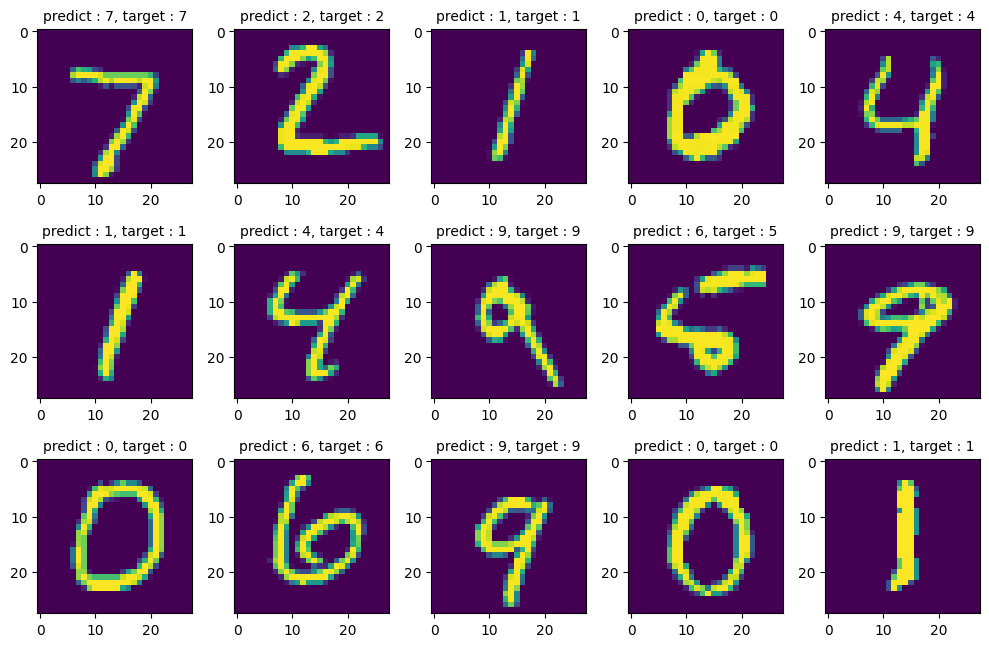

In [11]:
nrows, ncols = 3, 5

fig = plt.figure(figsize=(2 * ncols, 2.2 * nrows))

for i in range(nrows):
    for j in range(ncols):
        idx = i * ncols + j
        ax = fig.add_subplot(nrows, ncols, idx + 1)
        ax.imshow(x_test[idx])
        ax.set_title(
            f"predict : {test_t_preds[idx]}, target : {t_test[idx]}",
            fontdict={"size": 10},
        )

fig.tight_layout()